In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import re
sys.path.append('../')
data_path = '../data/'
model_path = '../models/'
from icd9 import *
from metrics import basic_micro_metrics, basic_macro_metrics
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(f'{data_path}restricted_mimic_iii/labeled_notes.csv')

In [3]:
# Get stop words from Perotte code
stop_words = []
with open(data_path + 'stopwords.txt') as f:
    for line in f:
        stop_words.append(line[:-1])

In [4]:
# Text was pre-tokenized in prep-mimic-iii.ipynb, so will only remove
# stop-words and split here
def tokenize(text):
    return text.split()

For now, I will follow Perotte 2014 and use only the top 10,000 most frequent unigrams. 

In [5]:
# Next, fit tfidf to training data and transform other splits
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words,
                                   tokenizer=tokenize,
                                   ngram_range=(1,1),
                                   max_features=10000)

train_data = data.loc[data['split']=='train',:].reset_index()
val_data = data.loc[data['split']=='val',:].reset_index()
test_data = data.loc[data['split']=='test',:].reset_index()

train_X = tfidf_vectorizer.fit_transform(train_data['text'].values)
val_X = tfidf_vectorizer.transform(val_data['text'].values)
test_X = tfidf_vectorizer.transform(test_data['text'].values)

Below is a simple demo of fitting hierarchical and flat SVMs and then making predictions.

In [6]:
# Instantiate ICD-9 tree and build index for train_data
tree = ICD9Tree(f'{data_path}node_desc.csv', f'{data_path}node_parent.csv')
tree.index_df(train_data, codes='fcode')

In [7]:
# Fit models and make predictions for entire ICD-9 tree
test_node = tree.root

To retrain and save the models, flip the comments in the two cells below. Otherwise, simply load the saved models from pickle files.

In [8]:
#tree.fit_hmodel(train_X, test_node, max_depth=None)
#tree.save_models(model_path+'hsvm_C1.obj', model_type='h')
tree.load_models(model_path+'hsvm_C1.obj', model_type='h')

In [9]:
#tree.fit_fmodel(train_X, test_node, max_depth=None)
#tree.save_models(model_path+'fsvm_C1_v2.obj', model_type='f')
tree.load_models(model_path+'fsvm_C1.obj', model_type='f')

In [10]:
h_preds_train = tree.predict_hmodel(train_X, test_node)
h_preds_val = tree.predict_hmodel(val_X, test_node)
h_preds_test = tree.predict_hmodel(test_X, test_node)

In [11]:
f_preds_train = tree.predict_fmodel(train_X, test_node)
f_preds_val = tree.predict_fmodel(val_X, test_node)
f_preds_test = tree.predict_fmodel(test_X, test_node)

In [12]:
h_train_micro = basic_micro_metrics(train_data['fcode'], h_preds_train)
h_valid_micro = basic_micro_metrics(val_data['fcode'], h_preds_val)
h_test_micro = basic_micro_metrics(test_data['fcode'], h_preds_test)

f_train_micro = basic_micro_metrics(train_data['fcode'], f_preds_train)
f_valid_micro = basic_micro_metrics(val_data['fcode'], f_preds_val)
f_test_micro = basic_micro_metrics(test_data['fcode'], f_preds_test)

In [13]:
print('***Hierarchical model, training set')
print(f'{h_train_micro}\n')
print('***Hierarchical model, validation set')
print(f'{h_valid_micro}\n')
print('***Hierarchical model, test set')
print(f'{h_test_micro}\n')
print('***Flat model, training set')
print(f'{f_train_micro}\n')
print('***Flat model, validation set')
print(f'{f_valid_micro}\n')
print('***Flat model, test set')
print(f'{f_test_micro}\n')

***Hierarchical model, training set
{'micro-precision': 0.7348261283116965, 'micro-recall': 0.686060357656148, 'micro-f1': 0.7096064061179534}

***Hierarchical model, validation set
{'micro-precision': 0.5005394801373222, 'micro-recall': 0.3596321223439867, 'micro-f1': 0.4185445672455863}

***Hierarchical model, test set
{'micro-precision': 0.48930234702817355, 'micro-recall': 0.3500758775402481, 'micro-f1': 0.4081424642781592}

***Flat model, training set
{'micro-precision': 0.7993283456996592, 'micro-recall': 0.5556850343498312, 'micro-f1': 0.6556020859671302}

***Flat model, validation set
{'micro-precision': 0.6116552802699811, 'micro-recall': 0.2618485499841432, 'micro-f1': 0.36670943545203316}

***Flat model, test set
{'micro-precision': 0.6080872150644202, 'micro-recall': 0.2530186064924782, 'micro-f1': 0.3573483674824401}



In [14]:
h_train_macro = basic_macro_metrics(train_data['fcode'], h_preds_train, per_label=True)
h_valid_macro = basic_macro_metrics(val_data['fcode'], h_preds_val, per_label=True)
h_test_macro = basic_macro_metrics(test_data['fcode'], h_preds_test, per_label=True)

f_train_macro = basic_macro_metrics(train_data['fcode'], f_preds_train, per_label=True)
f_valid_macro = basic_macro_metrics(val_data['fcode'], f_preds_val, per_label=True)
f_test_macro = basic_macro_metrics(test_data['fcode'], f_preds_test, per_label=True)

In [15]:
print('***Hierarchical model, training set')
print(f'{h_train_macro[0]}\n')
print('***Hierarchical model, validation set')
print(f'{h_valid_macro[0]}\n')
print('***Hierarchical model, test set')
print(f'{h_test_macro[0]}\n')
print('***Flat model, training set')
print(f'{f_train_macro[0]}\n')
print('***Flat model, validation set')
print(f'{f_valid_macro[0]}\n')
print('***Flat model, test set')
print(f'{f_test_macro[0]}\n')

***Hierarchical model, training set
{'macro-precision': 0.7819920093208984, 'macro-recall': 0.5359932589919213, 'macro-f1': 0.5359932589919213}

***Hierarchical model, validation set
{'macro-precision': 0.17050331486874498, 'macro-recall': 0.10679123998802799, 'macro-f1': 0.10679123998802799}

***Hierarchical model, test set
{'macro-precision': 0.14810871689031394, 'macro-recall': 0.08145483797979271, 'macro-f1': 0.08145483797979271}

***Flat model, training set
{'macro-precision': 0.8345368049241042, 'macro-recall': 0.5342417491251188, 'macro-f1': 0.5342417491251188}

***Flat model, validation set
{'macro-precision': 0.14966052012783868, 'macro-recall': 0.06764878129345472, 'macro-f1': 0.06764878129345472}

***Flat model, test set
{'macro-precision': 0.13088182566247558, 'macro-recall': 0.04760593125782685, 'macro-f1': 0.04760593125782685}



In [16]:
h_valid_df = pd.DataFrame(h_valid_macro[1])
f_valid_df = pd.DataFrame(f_valid_macro[1])

Finally, I will review per-label performance on the validation set against number of occurences of the label in the validation set. Number of occurences in the validation set serves as a proxy for the relative amount of training data available for a label. 

The results are noisy, particularly with fewer samples, but overall the performance does improve for more common labels, likely owing to the increased amount of relevant training data. 

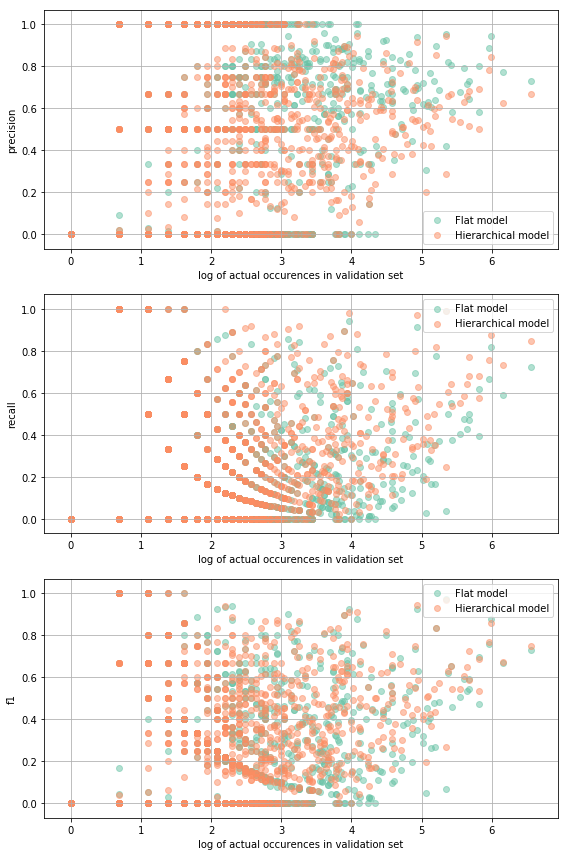

In [17]:
def subplot_helper(ax, metric, f_df, h_df):
    # Credit: http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
    f_df.sort_values('support', inplace=True)
    h_df.sort_values('support', inplace=True)
    colors = ['#66c2a5','#fc8d62','#8da0cb']
    ax.scatter(np.log(f_df.support+1), f_df[metric], color=colors[0], label='Flat model', alpha=0.5)
    ax.scatter(np.log(h_df.support+1), h_df[metric], color=colors[1], label='Hierarchical model', alpha=0.5)
    ax.set_xlabel('log of actual occurences in validation set')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

fig, axs = plt.subplots(3,1, figsize=(8,12))
subplot_helper(axs[0], 'precision', f_valid_df, h_valid_df)
subplot_helper(axs[1], 'recall', f_valid_df, h_valid_df)
subplot_helper(axs[2], 'f1', f_valid_df, h_valid_df)
fig.tight_layout()
plt.show()